In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
import pandas as pd
import time
from matplotlib.gridspec import GridSpec
%matplotlib inline

EPS = 1e-5
np.random.seed(42)

In [2]:
def vect_product(i1, j1, i2, j2):
    return i1 * j2 - j1 * i2

def scalar_product(i1, j1, i2, j2):
    return i1 * i2 + j1 * j2

In [3]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
        self._delta = []
        self.k = 0
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '@' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '@' or c == 'T':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j <= self._width) and (0 <= i <= self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        if i == self._height or j == self._width:
            return True
        return not self._cells[i][j]
    
    
    def _make_delta(self, k):
        if k == self.k:
            return
        self.k = k
        delta = [(-1, 0), (0, 1)]
        for _ in range(k - 2):
            new_delta = []
            for i in range(len(delta) - 1):
                new_direction = (delta[i][0] + delta[i + 1][0], delta[i][1] + delta[i + 1][1])
                new_delta.append(delta[i])
                new_delta.append(new_direction)
            new_delta.append(delta[-1])
            delta = new_delta
        delta.pop(-1)
        for elem in delta:
            self._delta.append(elem)
        for elem in delta:
            self._delta.append((elem[1], -elem[0]))
        for elem in delta:
            self._delta.append((-elem[0], -elem[1]))
        for elem in delta:
            self._delta.append((-elem[1], elem[0]))
    
    
    def _neighbor_cells(self, i, j):
        res = []
        for delta_i, delta_j in [(-1, 0), (0, 0), (0, -1), (-1, -1)]:
            res.append((i + delta_i, j + delta_j))
        return res
    
    def _nodes_of_cell(self, i, j):
        res = []
        for delta_i, delta_j in [(0, 0), (1, 0), (1, 1), (0, 1)]:
            res.append((i + delta_i, j + delta_j))
        return res
    
    def _neighbor_obstacles(self, i, j):
        '''
        Returns a list with flags o obstacles above cells around (i, j)
        '''
        is_obst = []
        for cell in self._neighbor_cells(i, j):
            is_obst.append(self.in_bounds(*cell) and not self.traversable(*cell))
        return is_obst
    
    
    def _diagonal_obstacles(self, i, j):
        is_obst = self._neighbor_obstacles(i, j)
        return is_obst[0] and is_obst[2] or is_obst[1] and is_obst[3]
        
        
    def _ortogonal_move_is_correct(self, i1, j1, i2, j2):
        move = (i2 - i1, j2 - j1)
        ortogonal_moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        nodes_to_check = self._neighbor_cells(i1, j1)
        for i in range(4):
            if ortogonal_moves[i] == move:
                node1 = nodes_to_check[i]
                node2 = nodes_to_check[(i + 1) % 4]
                return (self.in_bounds(*node1) and self.traversable(*node1)) or (self.in_bounds(*node2) and self.traversable(*node2))
        return False
    
    
    def _move_is_correct(self, i1, j1, i2, j2):
        if not self.in_bounds(i2, j2):
            return False
        
        if abs(i2 - i1) + abs(j2 - j1) == 1:
            return self._ortogonal_move_is_correct(i1, j1, i2, j2)
        
        
        vect_product_sign = []
        step_i = (i2 > i1) * 2 - 1
        step_j = (j2 > j1) * 2 - 1
        for i in range(i1, i2 + step_i, step_i):
            vect_product_sign.append([])
            for j in range(j1, j2 + step_j, step_j):
                vect_product = (i2 - i1) * (j - j1) - (j2 - j1) * (i - i1)
                vect_product_sign[-1].append(1 if vect_product > 0
                                             else -1 if vect_product < 0
                                             else 0)
        
        for i in range(i1, i2 + step_i, step_i):
            for j in range(j1, j2 + step_j, step_j):
                if (i, j) != (i1, j1) and (i, j) != (i2, j2):
                    if self._diagonal_obstacles(i, j):
                        return False
        for i in range(i1 - (step_i == -1), i2 - (step_i == -1), step_i):
            for j in range(j1 - (step_j == -1), j2 - (step_j == -1), step_j):
                if self.traversable(i, j):
                    continue
                vp_signs = set()
                for node in self._nodes_of_cell(i, j):
                    vp_signs.add(vect_product_sign[abs(node[0] - i1)][abs(node[1] - j1)])
                if (1 in vp_signs) and (-1 in vp_signs):
                    return False
        return True
    
    def get_neighbors(self, i, j, k):
        neighbors = []
        self._make_delta(k)
        for d in self._delta:
            if self._move_is_correct(i, j, i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
        return neighbors

    def get_natural_neighbors(self, i, j, number_of_prev_move, k):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 4-connected (i.e. only moves into cardinal directions are allowed)
        '''
        neighbors = []
        self._make_delta(k)
        if number_of_prev_move is None:
            for ind, d in enumerate(self._delta):
                if self._move_is_correct(i, j, i + d[0], j + d[1]):
                    neighbors.append((i + d[0], j + d[1], ind))
            return neighbors
        if number_of_prev_move % 2:
            for ind in range(-1, 2):
                number_of_current_move = (number_of_prev_move + ind + 2**k) % 2**k
                d = self._delta[number_of_current_move]
                if self._move_is_correct(i, j, i + d[0], j + d[1]):
                    neighbors.append((i + d[0], j + d[1], number_of_current_move))
        else:
            d = self._delta[number_of_prev_move]
            if self._move_is_correct(i, j, i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1], number_of_prev_move))
        return neighbors
    
    def get_forced_neighbors(self, i, j, number_of_prev_move, k):
        if number_of_prev_move is None:
            return []
        neighbors = []
        self._make_delta(k)
        # ortogonal moves around an obstacle
        m1_ind = -1
        m2_ind = -1
        if sum(self._neighbor_obstacles(i, j)) == 1:
            for ind, cell in enumerate(self._neighbor_cells(i, j)):
                if not self.traversable(*cell):
                    m1_ind = ind * 2**(k - 2)
                    m2_ind = ((ind + 1) % 4) * 2**(k - 2)
                    break
            v1 = vect_product(*self._delta[m1_ind], *self._delta[number_of_prev_move])
            v2 = vect_product(*self._delta[m2_ind], *self._delta[number_of_prev_move])
            if v1 * v2 < 0 or m1_ind == number_of_prev_move or m2_ind == number_of_prev_move:
                return []
            s1 = scalar_product(*self._delta[m1_ind], *self._delta[number_of_prev_move])
            s2 = scalar_product(*self._delta[m2_ind], *self._delta[number_of_prev_move])
            ind1 = -1
            ind2 = -1
            if s1 > s2:
                ind1 = number_of_prev_move + 1
                ind2 = m1_ind
            else:
                ind1 = m2_ind
                ind2 = number_of_prev_move - 1
            if ind1 > ind2:
                ind2 += 2**k
            for ind in range(ind1, ind2 + 1):
                number_of_current_move = ind % 2**k
                d = self._delta[number_of_current_move]
                if self._move_is_correct(i, j, i + d[0], j + d[1]):
                    neighbors.append((i + d[0], j + d[1], number_of_current_move))
        return neighbors

    def get_size(self):
        return (self._height, self._width)

In [4]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves between cells
    '''
    squared_dist = (i1 - i2)**2 + (j1 - j2)**2
    return np.sqrt(squared_dist)

In [5]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    '''
    

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None, number_of_move = None, tie_breaking_func = None):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent
        self.number_of_move = number_of_move

        
    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)


    def __lt__(self, other): 
        '''
        Comparing the keys (i.e. the f-values) of two nodes,
        which is needed to sort/extract the best element from OPEN.
        
        This comparator is very basic. We will code a more plausible comparator further on.
        '''
        return self.f < other.f

In [6]:
class SearchTreePQS: #SearchTree which uses PriorityQueue for OPEN and set for CLOSED
    
    def __init__(self):
        self._open = []
        self._closed = set()
        self._true_value_computed = set()
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
    
    def remove_open_dublicates(self):
        while len(self._open) and self._open[0] in self._closed:
            heappop(self._open)
                    
    def open_is_empty(self):
        self.remove_open_dublicates()
        return len(self._open) == 0
    
    def add_to_open(self, item):
        heappush(self._open, item)
    
    def get_best_node_from_open(self):
        self.remove_open_dublicates()
        return None if self.open_is_empty() else heappop(self._open)

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

In [7]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [8]:
def length(i, j):
    return np.sqrt(i**2 + j**2)

def euclidian_distance(i1, j1, i2, j2, *args):
    return length(i1 - i2, j1 - j2)

In [9]:
def h_2k(i1, j1, i2, j2, k):
    x = abs(i2 - i1)
    y = abs(j2 - j1)
    l = [1, 0]
    r = [0, 1]
    for _ in range(k - 2):
        if x > y:
            r[0] += l[0]
            r[1] += l[1]
            x -= y
        else:
            l[0] += r[0]
            l[1] += r[1]
            y -= x
    return x * length(*l) + y * length(*r)

In [10]:
# using for counting statistics and returning it as one variable
class Stats:
    def __init__(self):
        self.difficulty = 0
        self.expansions = 0 # algorithm must set this value
        self.runtime = 0 # algorithm must set this value
        self.way_length = 0 # algorithm must set this value
        self.suboptimal = 0
        self.max_tree_size = 0 # algorithm must set this value

In [11]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func=None, search_tree=None, w=1, k=2):
    stats = Stats()
    stats.runtime = time.time()    
    ast = search_tree()
    goal_node = Node(goal_i, goal_j)
    path_found = False

    ast.add_to_open(Node(start_i, start_j,
                         h=w * heuristic_func(start_i, start_j, goal_i, goal_j, k)
                        if heuristic_func else 0))
    while not ast.open_is_empty():
        stats.max_tree_size = max(stats.max_tree_size, len(ast))
        curr_node = ast.get_best_node_from_open()
        ast.add_to_closed(curr_node)
        if curr_node == goal_node:
            path_found = True
            goal_node = curr_node # define g*-value in variable
            break
        stats.expansions += 1
        for i, j in grid_map.get_neighbors(curr_node.i, curr_node.j, k):
            nxt_node = Node(i, j, g=curr_node.g + compute_cost(curr_node.i, curr_node.j, i, j), 
                            h=w * heuristic_func(i, j, goal_i, goal_j, k)
                            if heuristic_func else 0,
                            parent=curr_node)
            if not ast.was_expanded(nxt_node):
                ast.add_to_open(nxt_node)
    stats.max_tree_size = max(stats.max_tree_size, len(ast))
                
    if not path_found:
        goal_node = None
    else:
        stats.way_length = goal_node.g
    stats.runtime = time.time() - stats.runtime
    return path_found, goal_node, stats, ast.OPEN, ast.CLOSED

In [12]:
def canonical_astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func=None, search_tree=None, w=1, k=2):
    stats = Stats()
    stats.runtime = time.time()    
    ast = search_tree()
    goal_node = Node(goal_i, goal_j)
    path_found = False

    ast.add_to_open(Node(start_i, start_j,
                         h=w * heuristic_func(start_i, start_j, goal_i, goal_j, k)
                        if heuristic_func else 0))
    while not ast.open_is_empty():
        stats.max_tree_size = max(stats.max_tree_size, len(ast))
        curr_node = ast.get_best_node_from_open()
        ast.add_to_closed(curr_node)
        if curr_node == goal_node:
            path_found = True
            goal_node = curr_node # define g*-value in variable
            break
        stats.expansions += 1
        neighbors = grid_map.get_natural_neighbors(curr_node.i, curr_node.j, curr_node.number_of_move, k) +\
        grid_map.get_forced_neighbors(curr_node.i, curr_node.j, curr_node.number_of_move, k)
        for i, j, num in neighbors:
            nxt_node = Node(i, j, g=curr_node.g + compute_cost(curr_node.i, curr_node.j, i, j), 
                            h=w * heuristic_func(i, j, goal_i, goal_j, k)
                            if heuristic_func else 0,
                            parent=curr_node, number_of_move=num)
            if not ast.was_expanded(nxt_node):
                ast.add_to_open(nxt_node)
    stats.max_tree_size = max(stats.max_tree_size, len(ast))
                
    if not path_found:
        goal_node = None
    else:
        stats.way_length = goal_node.g
    stats.runtime = time.time() - stats.runtime
    return path_found, goal_node, stats, ast.OPEN, ast.CLOSED

# Visualization

In [33]:
def draw(grid_map, start = None, goal = None, path = None, nodes_opened = None, nodes_expanded = None, nodes_reexpanded = None):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the open/expanded/re-expanded nodes.
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 5
    height, width = grid_map.get_size()
        
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    for i in range(height):
        for j in range(width):
            if(not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodes_opened is not None:
        nodes_coords = []
        for node in nodes_opened:
            nodes_coords.append((node.j * k, node.i * k))
        draw.point(nodes_coords, fill=(213, 219, 219))
    
    if nodes_expanded is not None:
        nodes_coords = []
        for node in nodes_expanded:
            nodes_coords.append((node.j * k, node.i * k))
        draw.point(nodes_coords, fill=(131, 145, 146))
    
    
    if path is not None:
        nodes_coords = []
        for step in path:
            nodes_coords.append((step.j * k, step.i * k))
        draw.line(nodes_coords, fill=(52, 152, 219))
        draw.point(nodes_coords, fill=(0, 0, 128))

    if (start is not None):
        draw.point((start.j * k, start.i * k), fill=(40, 180, 99))
    if (goal is not None):
        draw.point((goal.j * k, goal.i * k), fill=(231, 76, 60))


    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()


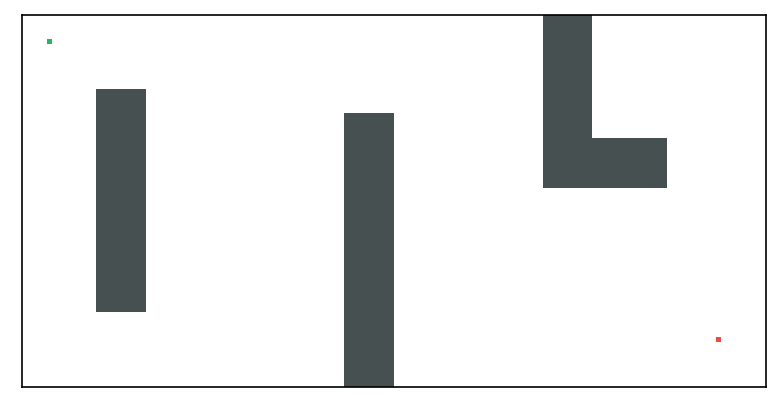

In [34]:
height = 15
width = 30
map_str = '''
. . . . . . . . . . . . . . . . . . . . . @ @ . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . @ @ . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . @ @ . . . . . . . 
. . . @ @ . . . . . . . . . . . . . . . . @ @ . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . @ @ . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . @ @ @ @ @ . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . @ @ @ @ @ . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . @ @ . . . . . . . . . . . . . . .
. . . . . . . . . . . . . @ @ . . . . . . . . . . . . . . .
'''

test_map = Map()
test_map.read_from_string(map_str, width, height)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

In [35]:
def simple_test(search_func, task, *args, **kwargs):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 15
    width = 30
    map_str = '''
. . . . . . . . . . . . . . . . . . . . . @ @ . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . @ @ . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . @ @ . . . . . . . 
. . . @ @ . . . . . . . . . . . . . . . . @ @ . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . @ @ . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . @ @ @ @ @ . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . @ @ @ @ @ . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . @ @ . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . @ @ . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . @ @ . . . . . . . . . . . . . . .
. . . . . . . . . . . . . @ @ . . . . . . . . . . . . . . .
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    lengths = [36, 30, 30, 21, 28, 24, 32, 27, 42, 23, 35, 37, 23, 26, 40, 36, 42, 28, 44, 36, 38, 29, 33, 42, 44]

    if (task is None) or not (0 <= task < 25):
        task = randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args, **kwargs)
        number_of_expansions = result[2].expansions
        nodes_created = result[2].max_tree_size
        nodes_opened = result[3]
        nodes_expanded = result[4]
        if result[0]:
            path = make_path(result[1])
            correct = int(path[1])  == int(length)
            print("Path found! Length: " + str(path[1]) + \
                ". Nodes created: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_expansions) + ". Correct: " + str(correct) + \
                 ". Runtime: " + str(result[2].runtime) + "ms.")
            draw(task_map, start, goal, path[0], nodes_opened, nodes_expanded)
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)


Path found! Length: 25.99358721828541. Nodes created: 2660. Number of steps: 197. Correct: False. Runtime: 0.4722316265106201ms.


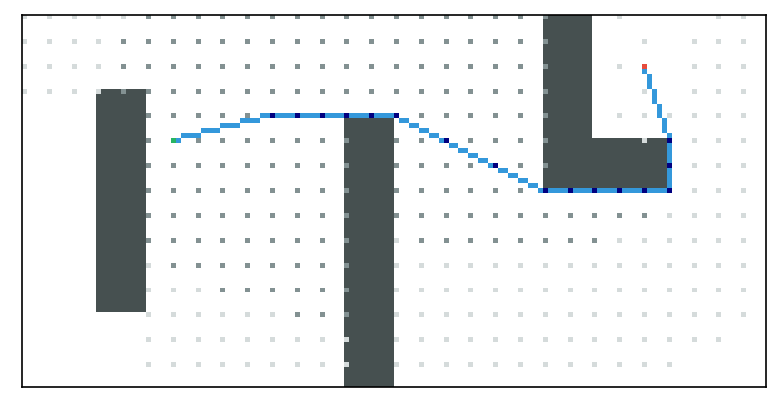

In [36]:
stats = simple_test(astar, 6, h_2k, SearchTreePQS, k=6)

Path found! Length: 27.384776310850242. Nodes created: 313. Number of steps: 290. Correct: False. Runtime: 0.007987737655639648ms.


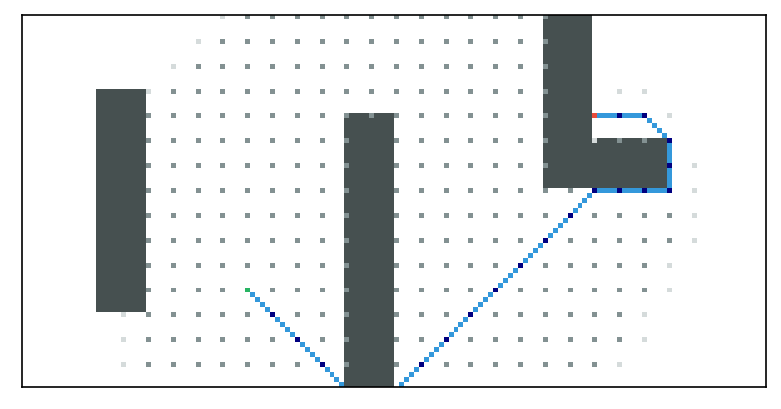

In [37]:
stats = simple_test(canonical_astar, 10, h_2k, SearchTreePQS, k=3)